In [ ]:

import random
from google.colab import drive
import pandas as pd
import numpy as np
import os
import seaborn as sns
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Bidirectional
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report # Import classification_report
import keras.backend as K
from sklearn.model_selection import train_test_split

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1].split('.')[0]
        labels.append(label.lower())

print('Dataset Loaded')


Dataset Loaded


label
ps         800
sad        800
disgust    800
fear       800
neutral    800
happy      800
angry      800
Name: count, dtype: int64


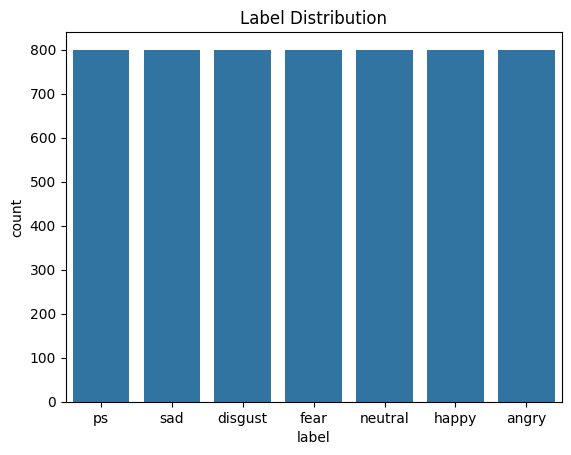

In [ ]:
df = pd.DataFrame({'speech': paths, 'label': labels})
print(df['label'].value_counts())
sns.countplot(data=df, x='label')
plt.title('Label Distribution')
plt.show()


In [ ]:
# Waveplot and Spectrogram
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


In [ ]:
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


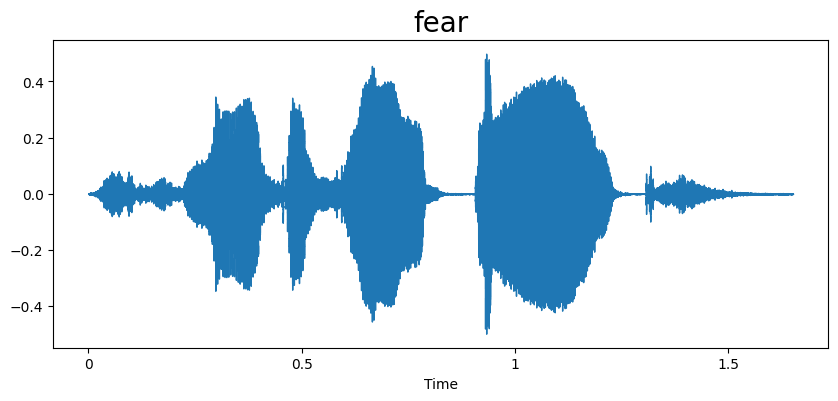

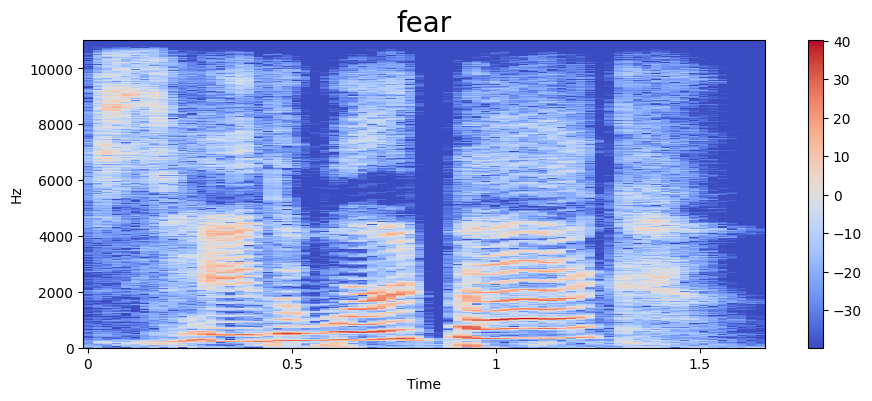

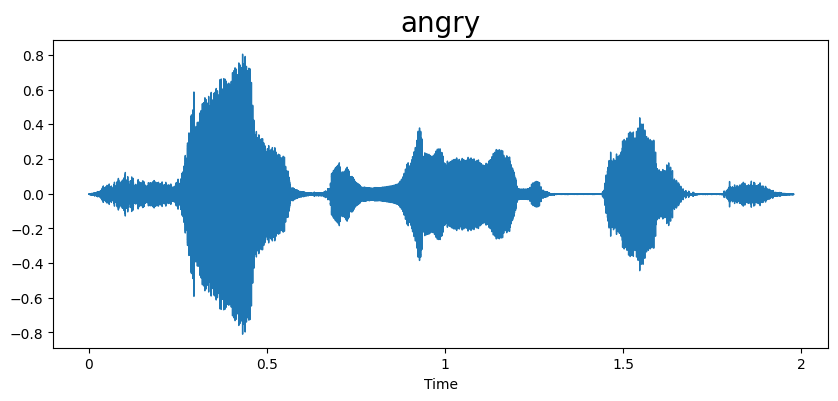

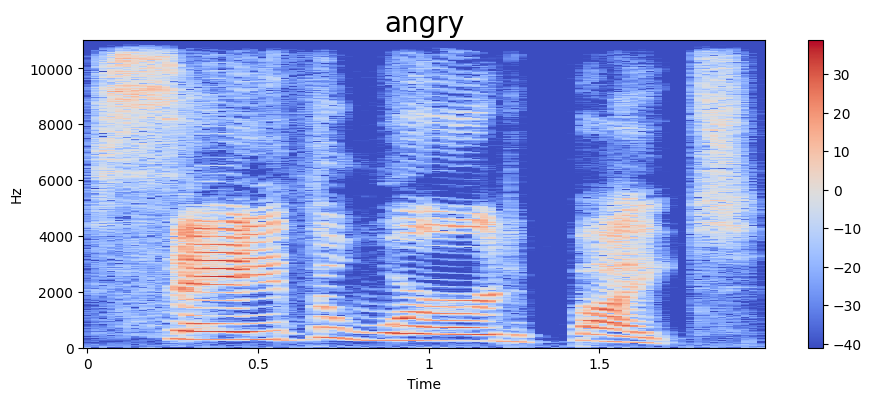

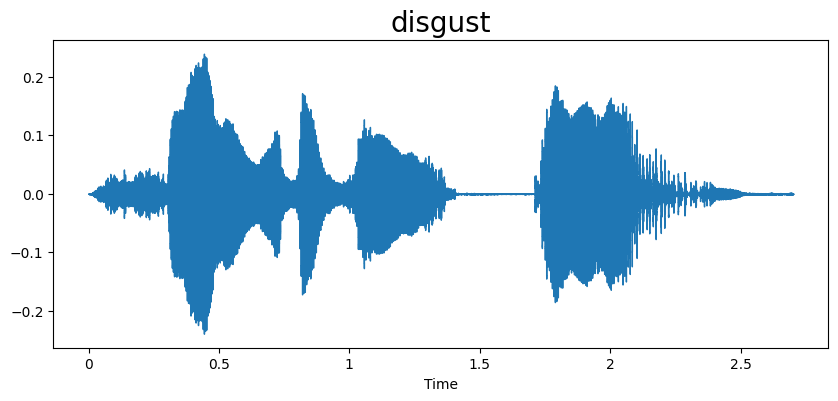

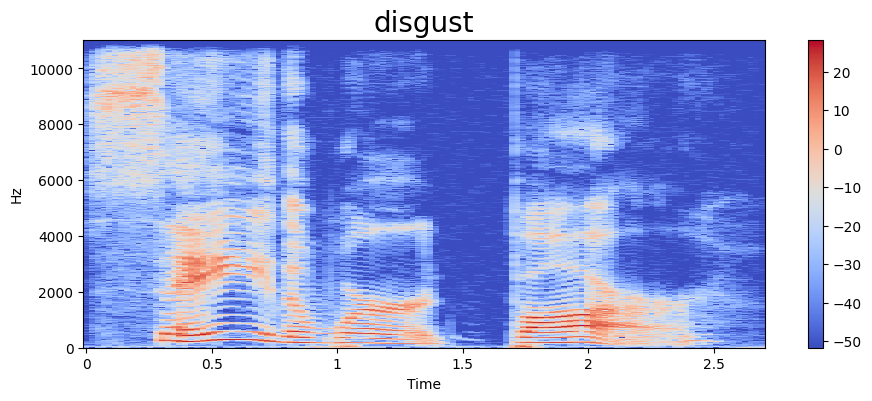

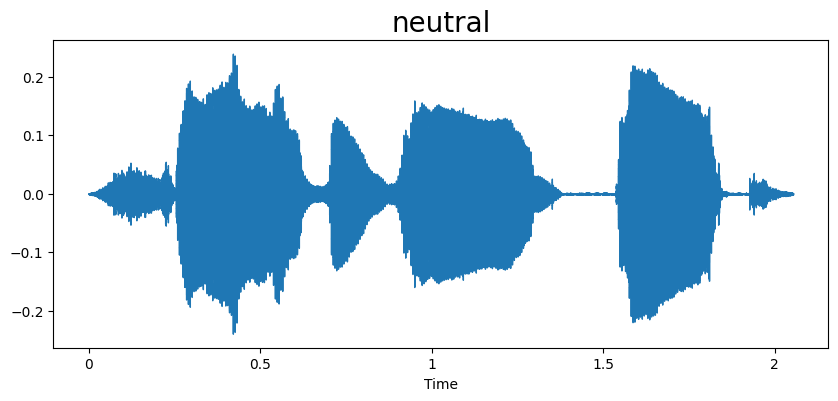

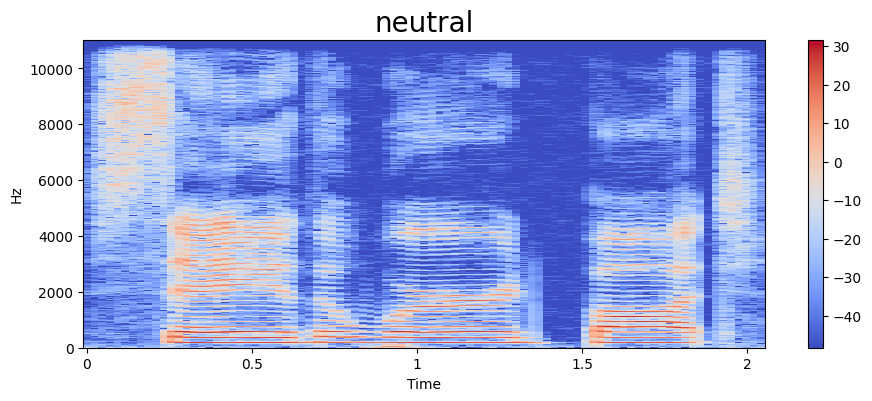

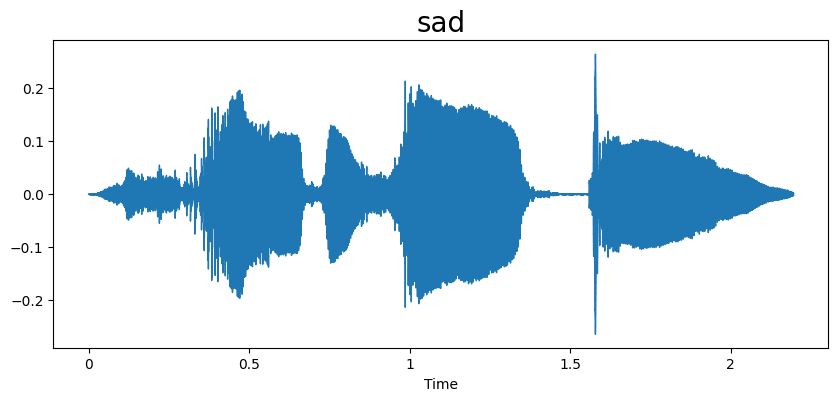

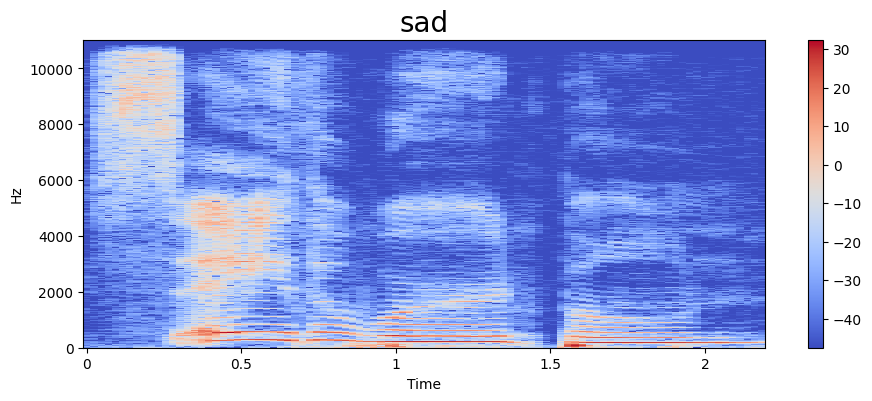

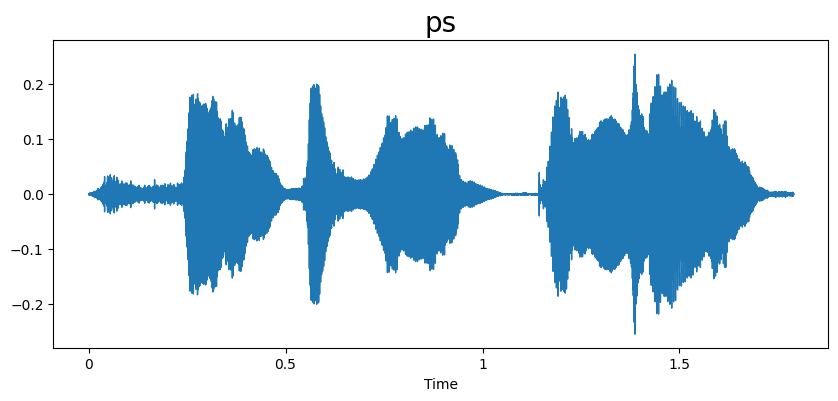

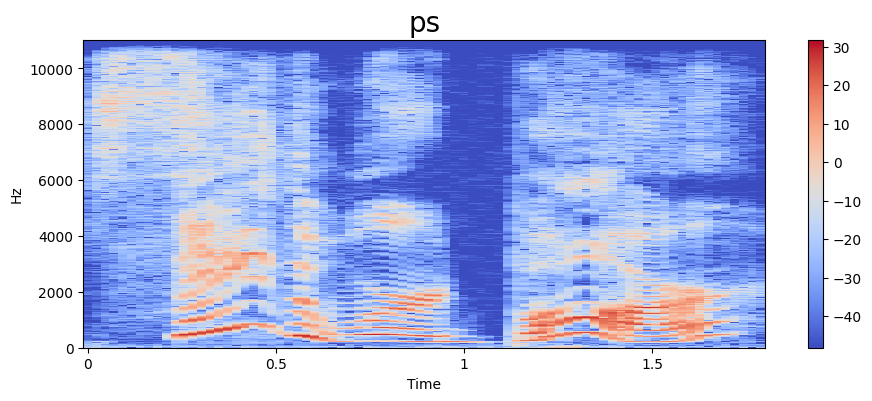

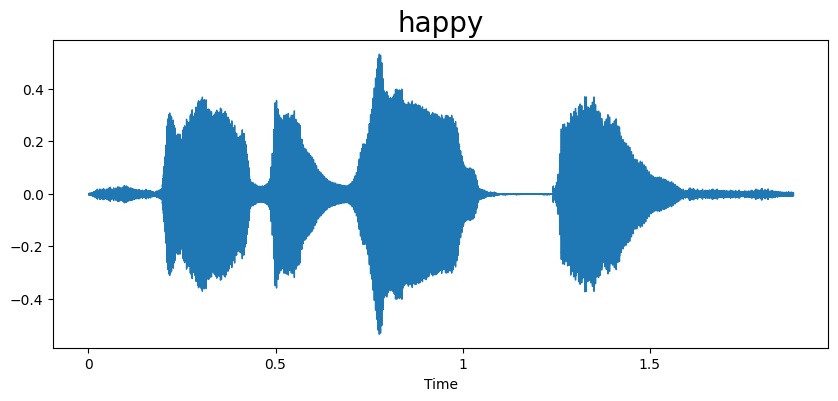

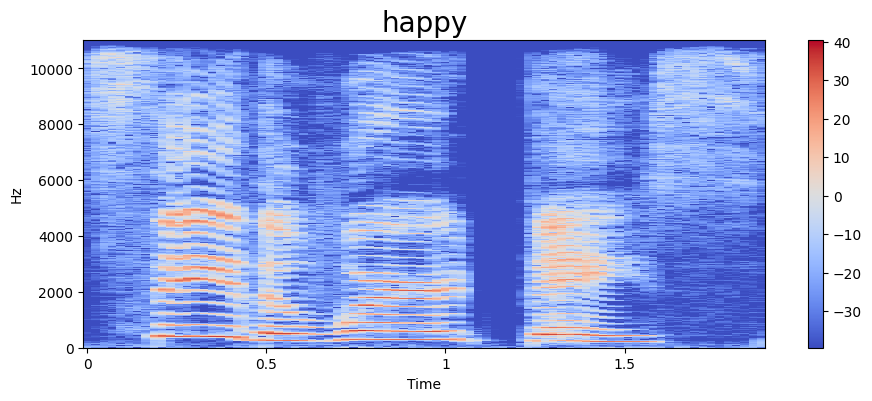

In [ ]:
emotions = ['fear', 'angry', 'disgust', 'neutral', 'sad', 'ps', 'happy']
for emotion in emotions:
    path = np.array(df['speech'][df['label'] == emotion])[0]
    data, sr = librosa.load(path)
    waveplot(data, sr, emotion)
    spectogram(data, sr, emotion)
    display(Audio(path))


In [ ]:
# MFCC feature extraction
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc


In [ ]:
x_mfcc = df['speech'].apply(extract_mfcc)
X = np.array([x for x in x_mfcc])
X = np.expand_dims(X, -1)
print("Feature shape:", X.shape)



Feature shape: (5600, 40, 1)


In [ ]:
# Label encoding
y = to_categorical(LabelEncoder().fit_transform(df['label']))
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label'])
print("Encoded Labels:", label_encoder.classes_)



Encoded Labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(40, 1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=512, shuffle=True)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,127 (301.28 KB)

 Trainable params: 77,127 (301.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2303 - loss: 1.8777 - val_accuracy: 0.4911 - val_loss: 1.6249
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4650 - loss: 1.5785 - val_accuracy: 0.6196 - val_loss: 1.1922
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5524 - loss: 1.2009 - val_accuracy: 0.7063 - val_loss: 0.7958
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6465 - loss: 0.8833 - val_accuracy: 0.8179 - val_loss: 0.5277
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7462 - loss: 0.6659 - val_accuracy: 0.8625 - val_loss: 0.3644
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8263 - loss: 0.4897 - val_accuracy: 0.9054 - val_loss: 0.2555
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8891 - loss: 0.3505 - val_accuracy: 0.9286 - val_loss: 0.1902
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9316 - loss: 0.2509 - val_accuracy: 0.9402 - val_loss:

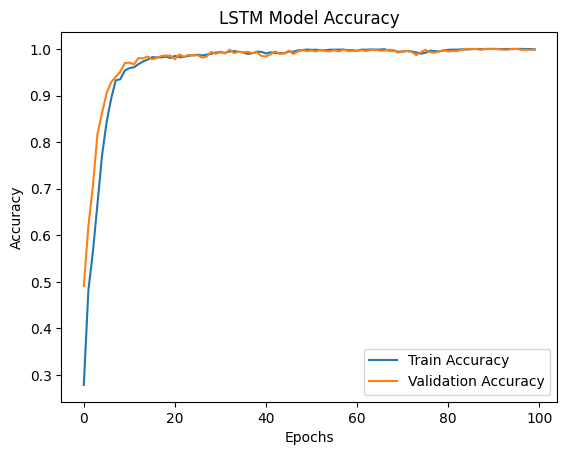

In [ ]:
# Accuracy & Loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


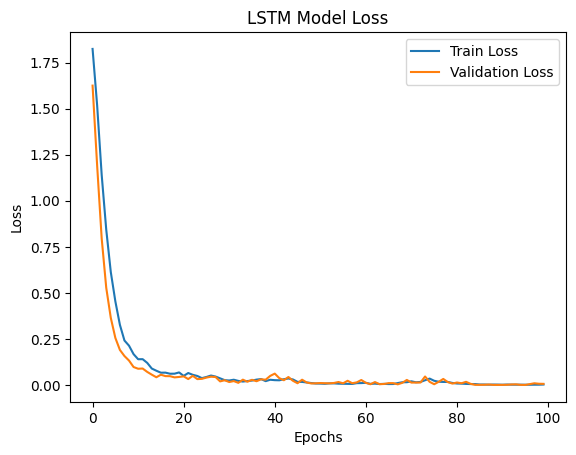

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate LSTM
_, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy (LSTM):", test_acc)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9950 - loss: 0.0170
Test Accuracy (LSTM): 0.9982143044471741


In [ ]:
# LSTM predictions
y_pred_lstm = model.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_true_lstm = np.argmax(y_test, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


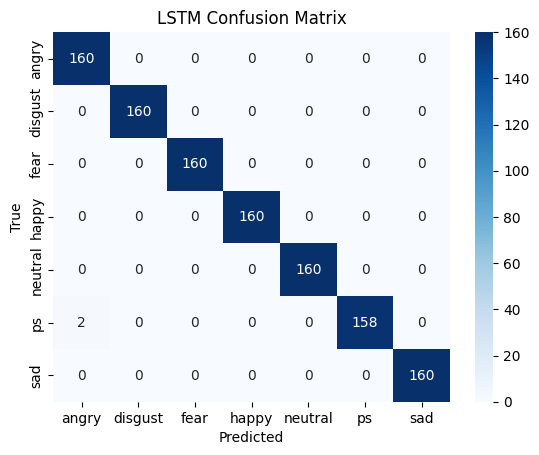

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_lstm, y_pred_classes_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report # Import classification_report


In [ ]:
# Classification report (LSTM)
print("\nLSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_classes_lstm, target_names=label_encoder.classes_))


LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.99      1.00      0.99       160
     disgust       1.00      1.00      1.00       160
        fear       1.00      1.00      1.00       160
       happy       1.00      1.00      1.00       160
     neutral       1.00      1.00      1.00       160
          ps       1.00      0.99      0.99       160
         sad       1.00      1.00      1.00       160

    accuracy                           1.00      1120
   macro avg       1.00      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120



In [ ]:

# Show LSTM predictions
decoded_preds_lstm = label_encoder.inverse_transform(y_pred_classes_lstm)
decoded_actuals_lstm = label_encoder.inverse_transform(y_true_lstm)
print("\nLSTM Sample Predictions:")
for i in random.sample(range(len(X_test)), 10):
    print(f"Actual: {decoded_actuals_lstm[i]}  -->  Predicted: {decoded_preds_lstm[i]}")



LSTM Sample Predictions:
Actual: sad  -->  Predicted: sad
Actual: neutral  -->  Predicted: neutral
Actual: angry  -->  Predicted: angry
Actual: happy  -->  Predicted: happy
Actual: ps  -->  Predicted: ps
Actual: happy  -->  Predicted: happy
Actual: angry  -->  Predicted: angry
Actual: angry  -->  Predicted: angry
Actual: disgust  -->  Predicted: disgust
Actual: fear  -->  Predicted: fear


In [ ]:
# GRU model
from tensorflow.keras.layers import GRU # Add this import statement

model_gru = Sequential([
    GRU(128, return_sequences=False, input_shape=(40, 1)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

In [ ]:
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_gru.summary()
history_gru = model_gru.fit(X, y, validation_split=0.2, epochs=100, batch_size=64)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,871 (237.78 KB)

 Trainable params: 60,871 (237.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9954 - loss: 0.0169 - val_accuracy: 0.9750 - val_loss: 0.0947
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9923 - loss: 0.0506 - val_accuracy: 0.9955 - val_loss: 0.0129
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9979 - loss: 0.0071 - val_accuracy: 0.9964 - val_loss: 0.0131
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 0.9973 - val_loss: 0.0069
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9975 - loss: 0.0092 - val_accuracy: 0.9991 - val_loss: 0.0046
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9982 - loss: 0.0079 - val_accuracy: 0.9982 - val_loss: 0.0071
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9903 - loss: 0.0401 - val_accuracy: 0.9857 - val_loss: 0.0443
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9952 - loss: 0.0202 - val_accuracy: 0.9973 -

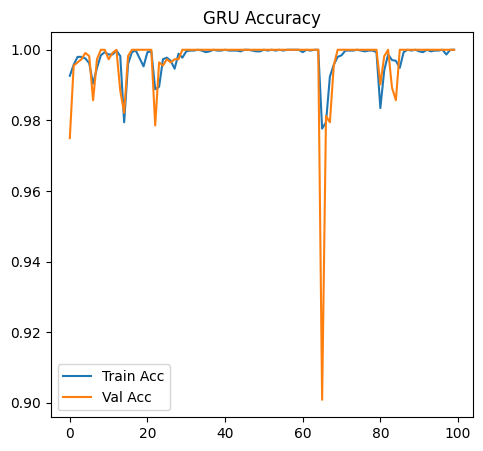

In [ ]:
# Accuracy & loss (GRU)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Acc')
plt.plot(history_gru.history['val_accuracy'], label='Val Acc')
plt.title('GRU Accuracy')
plt.legend()

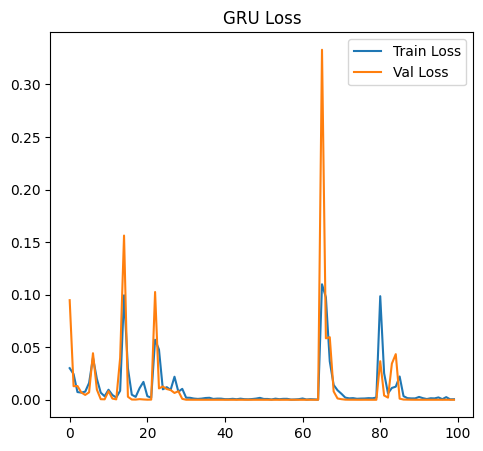

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Loss')
plt.legend()
plt.show()

In [ ]:
# GRU evaluation on test set
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test, y_test)
print("\nGRU Test Accuracy:", test_acc_gru)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9123e-07

GRU Test Accuracy: 1.0


In [ ]:
# GRU predictions
y_pred_gru = model_gru.predict(X_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_true_gru = np.argmax(y_test, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


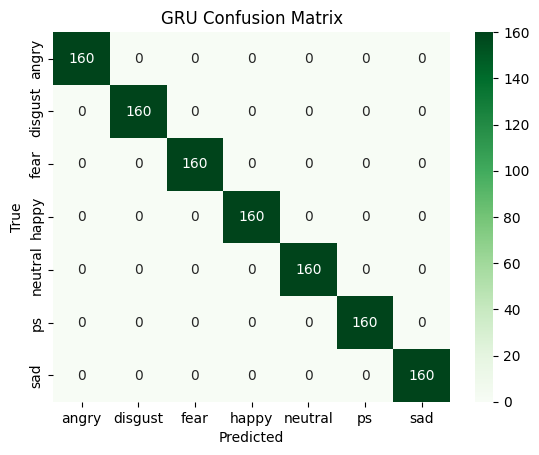

In [ ]:
# Confusion matrix (GRU)
cm_gru = confusion_matrix(y_true_gru, y_pred_classes_gru)
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('GRU Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification report (GRU)
print("\nGRU Classification Report:")
print(classification_report(y_true_gru, y_pred_classes_gru, target_names=label_encoder.classes_))



GRU Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       160
     disgust       1.00      1.00      1.00       160
        fear       1.00      1.00      1.00       160
       happy       1.00      1.00      1.00       160
     neutral       1.00      1.00      1.00       160
          ps       1.00      1.00      1.00       160
         sad       1.00      1.00      1.00       160

    accuracy                           1.00      1120
   macro avg       1.00      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120



In [ ]:
# GRU predictions sample
decoded_preds_gru = label_encoder.inverse_transform(y_pred_classes_gru)
decoded_actuals_gru = label_encoder.inverse_transform(y_true_gru)
print("\nGRU Sample Predictions:")
for i in random.sample(range(len(X_test)), 10):
    print(f"Actual: {decoded_actuals_gru[i]}  -->  Predicted: {decoded_preds_gru[i]}")


GRU Sample Predictions:
Actual: neutral  -->  Predicted: neutral
Actual: angry  -->  Predicted: angry
Actual: happy  -->  Predicted: happy
Actual: ps  -->  Predicted: ps
Actual: ps  -->  Predicted: ps
Actual: happy  -->  Predicted: happy
Actual: neutral  -->  Predicted: neutral
Actual: angry  -->  Predicted: angry
Actual: sad  -->  Predicted: sad
Actual: sad  -->  Predicted: sad
